In [189]:
import os
import numpy as np
import scipy
import dedalus.public as d3
from dedalus.core import evaluator
import logging
from mpi4py import MPI
logger = logging.getLogger(__name__)
import math

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 9})
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import colormaps

In [ ]:
"""
Code below is from Vasil's EVP code and is adapted to calculate the eigenvalues of a 'simpler' system.
"""

dtype = np.complex128
nphi = 1 #Axisymmetric
nth = 192 #Grid/No of points for theta
nr = 32 #Grid/No of points for radius
neig = 128 #No of eigenvalues

#Reynolds number (values just taken from Vasil's wrapper.py code)
Re = 6.0
myRe = 10**Re

M = -5.5
Mstr = "{:.2f}".format(M)
myM = (10e0)**M
guess = 0e0

target_m = 0
if (target_m==0):
        Mmax = 1
else:
        Mmax = 3*np.abs(target_m)

    # Original parameters
Lmax = nth
Nmax = nr

L_dealias = 3/2 #Dealias by x harmonics
N_dealias = 3/2 #Dealias by y orders

#Problem Parameters
ri = 0.89 #Inner radius
ro = 0.99 #Outer radius

Rev = Re
Pm = 1e0
Rm = Pm*Rev #Magnetic Reynolds number

Rei = 1e0/Rev
Rmi = 1e0/Rm
    
Mag = myM
sMag = np.sqrt(Mag)

# Set up output dir
#data_dir = 'ModelS_Fit_M{:.2f}_ellmax{:d}_m{:d}'.format(np.log10(Mag),Lmax,target_m)+'_'+label
data_dir = 'Test_MRI_Output'

#Define radii for coordinate system creators
radii = (ri,ro)

mesh = None
# Coordinates
coords = d3.SphericalCoordinates('phi', 'theta', 'r')
    
# Distributor
dist = d3.Distributor(coords, mesh=mesh, dtype=dtype)#,comm=comm)

# Basis
basis = d3.ShellBasis(coords, (Mmax,Lmax,Nmax), radii=radii, dtype=dtype, dealias=(L_dealias, L_dealias, N_dealias)) #, alpha=(0,0))
basis_k3 = d3.ShellBasis(coords, (Mmax,Lmax,Nmax), radii=radii, dtype=dtype, dealias=(L_dealias, L_dealias, N_dealias), k=3)

# Useful Basis components
b_inner = basis.S2_basis(radius=ri) #For inner sphere boundary conditions
b_outer = basis.S2_basis(radius=ro) #For outer sphere boundary conditions
b_merid = basis.meridional_basis #For 2D NCCs
b_merid_k3 = basis_k3.meridional_basis
lift_basis = basis.clone_with(k=1) # First derivative basis

# Coordinate arrays
phi, theta, r = dist.local_grids(basis) #Get local coordinate arrays

# Linear Fields
uu = dist.VectorField(coords, bases=basis, name='uu') #Velocity
pu = dist.Field(bases=basis, name='pu') #Pressure gauge

bb = dist.VectorField(coords, bases=basis, name='bb') #Magnetic field
pb = dist.Field(bases=basis, name='pb') #Magnetic gauge

#Background fields
v0 = dist.VectorField(coords, bases=b_merid, name='v0') #Background Velocity
w0 = dist.VectorField(coords, bases=b_merid, name='w0') #Background Planetary Vorticity
B0 = dist.VectorField(coords, bases=b_merid_k3, name='B0') #Background Magnetic Field times r^3
J0 = dist.VectorField(coords, bases=b_merid, name='J0') #Background Magnetic Field times r^3
er_drho = dist.VectorField(coords, bases=b_merid, name='er_drho') #Radial Unit Vector times drho/dr
rvec = dist.VectorField(coords, bases=b_merid, name='rvec') #Radial Vector
eye = d3.Field(dist=dist, bases=(b_merid,b_merid), tensorsig=(coords,coords), dtype=dtype, name='eye') #Identity tensor

#Non-constant coefficients to help with operator bandwidth
rho_ncc = dist.Field(bases=b_merid, name='rho') #rho for the continuity equation
rho_Rei = dist.Field(bases=b_merid, name='rho_Rei') #rho for the various hydro terms

# Eigenvalue
om = dist.Field(name='om')

#Taus for boundaries
#Inner boundary
tau_u_ri = dist.VectorField(coords, bases=b_inner, name='tau_u_ri')
tau_b_ri = dist.VectorField(coords, bases=b_inner, name='tau_b_ri')

#Outer boundary
tau_u_ro = dist.VectorField(coords, bases=b_outer, name='tau_u_ro')
tau_b_ro = dist.VectorField(coords, bases=b_outer, name='tau_b_ro')

#Gauge taus
tau_pu = dist.Field(name='tau_pu')
tau_pb = dist.Field(name='tau_pb')

# Operator shortcuts
lift = lambda A: d3.Lift(A, lift_basis, -1)
ddt = lambda A: -1j*om*A

#From jupyter notebook fitting (can update to be more general)... fixed to ri=0.89, ro=0.99 for now.
rho_cheby_coefs = [0.4287056,-0.50122643,0.07841967,0.00206746,0.00243878] #Good to 1%
drho_cheby_coefs = [-9.78493705,6.46519649,0.45630896,0.24012609,0.11130384] #Good to 2%
z = (2*r-ri-ro)/(ro-ri) #Chebyshev ordinate values between -1,1
rho = np.polynomial.chebyshev.chebval(z,rho_cheby_coefs)
drho = np.polynomial.chebyshev.chebval(z,drho_cheby_coefs)

rho_ncc['g'] = rho

#Non-force free magnetic field, but current stable?
#Normed so that |B0| = 1 at r=1, theta=pi/2
B0['g'][0] = 0
B0['g'][1] = -sMag*(4*r**5+ro**5)*np.sin(theta)/r**3/ro**2/5
B0['g'][2] = 2*sMag*(r**5-ro**5)*np.cos(theta)/r**3/ro**2/5

J0['g'][0] = -2*sMag*r*np.sin(theta)/ro**2
J0['g'][1] = 0
J0['g'][2] = 0

#Setup background velocity
z = (r-ri)/(ro-ri) #Scaled radial coordinate

fz = (1+0.02*z-0.01*z**2-0.03*z**3) #Radial structure in the rotating frame, from fit to solar data
dfz = (0.02-0.02*z-0.09*z**2)/(ro-ri) #Radial derivative of fz

gt = 1-0.145*np.cos(theta)**2-0.148*np.cos(theta)**4 #Angular part of the differential rotation
dgt = 2*np.sin(theta)*(0.145*np.cos(theta) + 2*0.148*np.cos(theta)**3) #theta derivative of gt

v0['g'][0] = r*np.sin(theta)*(fz*gt-1) #Phi component only, shifted to rotating frame
v0['g'][1] = 0*r
v0['g'][2] = 0*r

#Vorticity associated with v_0 multiplied by Rossby, plus the coriolis force
#(which cancels out terms from -rsint in the curl of v0), and then multiplied by the nccs to save build time
df = 2*fz + r*dfz
w0['g'][0] = 0
w0['g'][1] = -np.sin(theta)*df*gt
w0['g'][2] = fz*(2*np.cos(theta)*gt + np.sin(theta)*dgt)

#Radial unit vector, multiplied by drho for the two necessary terms
er_drho['g'][0]=0
er_drho['g'][1]=0
er_drho['g'][2]=drho

#Radial vector
rvec['g'][0] = 0
rvec['g'][1] = 0
rvec['g'][2] = r

#Identity tensor
eye['g'] = 0
for i in range(3):
    eye['g'][i,i] = 1

#Gradients with taus, for first-order formulation
grad_u = d3.grad(uu) + rvec*lift(tau_u_ri)
grad_b = d3.grad(bb) + rvec*lift(tau_b_ri)

# Viscosity tensor, includes taus for the momentum equation
sigma = grad_u + d3.transpose(grad_u) - (2/3)*d3.trace(grad_u)*eye

# Velocity boundary conditions, no taus in the grads
strain_rate = d3.grad(uu) + d3.transpose(d3.grad(uu))

# EMF for Magnetic boundary conditions (perfectly conducting)
emf = Rmi*d3.curl(bb) + d3.cross(B0,uu) + d3.cross(bb,v0)

logger.info("Building problem.")

# Problem
problem = d3.EVP([pu, uu, pb, bb, tau_u_ri, tau_b_ri, tau_u_ro, tau_b_ro, tau_pu, tau_pb], eigenvalue=om, namespace=locals())

#Equations of motion
problem.add_equation("rho_ncc*trace(grad_u) + dot(er_drho,uu) + tau_pu = 0")

#Vorticity based equation                                                              
problem.add_equation("rho_ncc*ddt(uu) - rho_ncc*Rei*div(sigma) - dot(er_drho*Rei,sigma) + rho_ncc*grad(pu) + cross(w0*rho_ncc,uu) + cross(curl(uu),v0*rho_ncc) + cross(B0,curl(bb)) + cross(bb,J0) + lift(tau_u_ro) = 0")

#Only aa
problem.add_equation("ddt(bb) - Rmi*div(grad_b) + grad(pb) + curl(cross(B0,uu)) + curl(cross(bb,v0)) + lift(tau_b_ro) = 0")

#Coloumb gauge
problem.add_equation("trace(grad_b) + tau_pb = 0")

# Gauges
problem.add_equation("integ(pu) = 0")
problem.add_equation("integ(pb) = 0")

#Boundary conditions
#Lower boundary
problem.add_equation("radial(uu(r=ri)) = 0")
problem.add_equation("angular(radial(strain_rate(r=ri),0),0) = 0")
problem.add_equation("angular(emf(r=ri),0) = 0")
problem.add_equation("radial(bb(r=ri)) = 0")

#Upper boundary
problem.add_equation("radial(uu(r=ro)) = 0")
problem.add_equation("angular(radial(strain_rate(r=ro),0),0) = 0")
problem.add_equation("angular(emf(r=ro),0) = 0") 
problem.add_equation("radial(bb(r=ro)) = 0")    

# Solver
print('Building solver.')
solver = problem.build_solver()
solver.ncc_cutoff = 1e-13
subproblem = solver.subproblems_by_group[(target_m, None, None)]
ss = subproblem.subsystems[0]

print('done building solver')

#Set initial guess for eigenvector 
uu['g'][0] = np.sin(theta)*np.sin(2*np.pi*r*np.sin(theta)/(ro-ri))
uu['g'][1] = 4*np.sin(theta)*((ro-ri)*(3*r**2+ri*ro-2*r*(ro+ri))*np.sin(2*np.pi*r*np.sin(theta)/(ro-ri))-2*np.pi*r*(r-ri)*(ro-r)*np.sin(theta)*np.cos(2*np.pi*r*np.sin(theta)/(ro-ri)))/(r*(ro-ri)**3)
uu['g'][2] = 8*(r-ri)*(r-ro)*np.cos(theta)*(np.pi*r*np.sin(theta)*np.cos(2*np.pi*r*np.sin(theta)/(ro-ri))+(ro-ri)*np.sin(2*np.pi*r*np.sin(theta)/(ro-ri)))/(r*(ro-ri)**3)

bb['g'][0] = np.cos(theta)*uu['g'][0]*np.sin(2*np.pi*(ro-r)*np.cos(theta)/(ro-ri))
bb['g'][1] = np.cos(theta)*uu['g'][1]
bb['g'][2] = np.cos(theta)*uu['g'][2] - 4*np.sin(theta)*(r-ri)*(ro-r)*np.sin(theta)*np.sin(2*np.pi*r*np.sin(theta)/(ro-ri))/(ro-ri)**2/r

uu['g'] = uu['g']/rho
umax = np.max(np.abs(uu['g'][0]))
uu['g'][0] = uu['g'][0]/umax
umax = np.max(np.abs(uu['g'][1:2]))
uu['g'][1:2] = uu['g'][1:2]/umax

bmax = np.max(np.abs(bb['g']))
bb['g'][1] = bb['g'][1]/bmax
bb['g'][2] = bb['g'][2]/bmax

#Solve for pu
tau_pu_ri = dist.Field(bases=b_inner, name='tau_pu_ri')
tau_pu_ro = dist.Field(bases=b_outer, name='tau_pu_ro')
grad_pu = d3.grad(pu) + rvec*lift(tau_pu_ri)

pu_prob = d3.LBVP([pu, tau_pu_ri, tau_pu_ro], namespace=locals())
pu_prob.add_equation("rho_ncc*div(grad_pu) + dot(er_drho,grad_pu) + lift(tau_pu_ro) = -div(rho_ncc*cross(w0,uu) + rho_ncc*cross(curl(uu),v0) + cross(bb,J0) + cross(B0,curl(bb)) - Rei*rho_ncc*div(sigma) - dot(Rei*er_drho,sigma))")
pu_prob.add_equation("pu(r=ri)=0")
pu_prob.add_equation("pu(r=ro)=0")

# Solver
pu_solver = pu_prob.build_solver()
pu_solver.solve()

pu.require_grid_space()

#Gather guess
eigv = ss.gather(solver.state)
#eigv = None

solver.solve_sparse(subproblem, neig, guess)#, whicheig='LM', eigv=eigv, invert=False) #,P=True)
logger.info('solved')
print(solver.eigenvalues)

namespace = {}
solver.evaluator = evaluator.Evaluator(solver.dist, namespace)

print('checkpointing in {}'.format(data_dir))

if not os.path.exists('{:s}'.format(data_dir)):
    os.mkdir('{:s}'.format(data_dir))

np.save(data_dir+'/eigenvalues.npy',solver.eigenvalues)
#np.save(data_dir+'/convergence.npy',solver.errors)
#A = (solver.eigenvalue_subproblem.L_min @ solver.eigenvalue_subproblem.pre_right)
#B = - (solver.eigenvalue_subproblem.M_min @ solver.eigenvalue_subproblem.pre_right)
#ainf = scipy.sparse.linalg.norm(A,ord=np.inf)
#A = A/ainf
#B = B/ainf
#scipy.sparse.save_npz(data_dir+'/A.npy',A)
#scipy.sparse.save_npz(data_dir+'/B.npy',B)
path = data_dir + '/checkpoints'
checkpoint = solver.evaluator.add_file_handler(path, max_writes=1)
checkpoint.add_tasks(solver.state)

for i in range(neig):
    solver.set_state(i, ss)
    solver.evaluator.evaluate_handlers([checkpoint],sim_time=1,wall_time=1,timestep=1,iteration=1)

problem = 0
solver = 0
pu_prob = 0
pu_solver = 0

2025-11-29 19:12:20,162 __main__ 0/1 INFO :: Building problem.
Building solver.
done building solver
2025-11-29 19:13:18,606 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 58s, Remaining: 0s, Rate: 1.7e-02/s
2025-11-29 19:24:11,668 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 10m 10s, Remaining: 0s, Rate: 1.6e-03/s
2025-11-29 19:26:53,892 __main__ 0/1 INFO :: solved
[-1.26474976e-18-6.39909099e-06j -1.55274432e-14-3.78329190e-01j
  3.92486822e-12-7.86764833e-01j  2.78723676e-15-1.13493162e+00j
  7.71819516e-13-1.96688390e+00j -3.72672485e-13-2.26978776e+00j
  1.48881505e-10-3.54033764e+00j -1.48066481e-13-3.78283861e+00j
  3.08610128e-10-5.50709393e+00j  1.00585580e-12-5.67400627e+00j
 -7.38668120e-14-7.86711196e+00j -3.21148130e-13-7.94319344e+00j
 -1.06803171e-09-1.06203429e+01j  5.49621705e-14-1.05902834e+01j
  1.73904640e-12-1.36151401e+01j -4.45976127e-13-1.37667295e+01j
 -2.41139593e-14-1.70176080e+01j  3.89564568e-12-1.730620

Text(0, 0.5, 'Background Velocity')

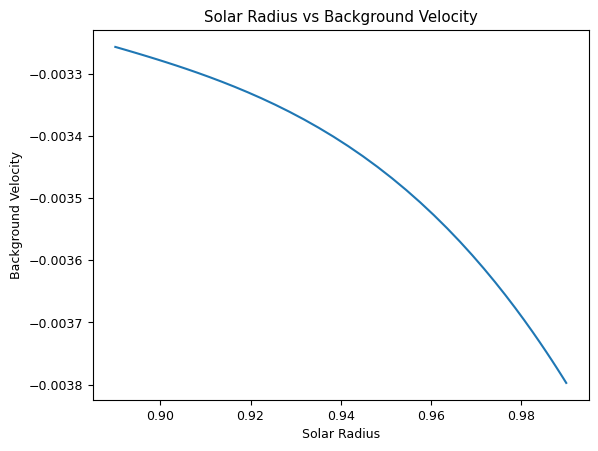

In [ ]:
#Plotting background velocity

import matplotlib.pyplot as plt


fig,ax=plt.subplots()
ax.plot(rvec['g'][2][0][0].real, v0['g'][0][0][0].real)
plt.title("Solar Radius vs Background Velocity")
plt.xlabel("Solar Radius")
plt.ylabel("Background Velocity")

Text(0, 0.5, 'Velocity Perturbation')

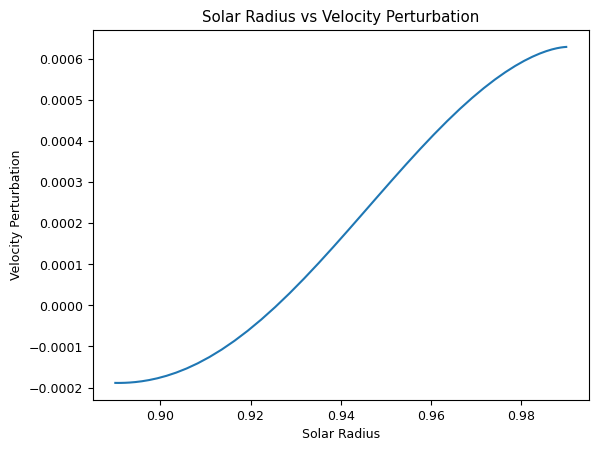

In [ ]:
#Plotting velocity perturbation

fig,ax = plt.subplots()

ax.plot(rvec['g'][2][0][0].real, uu['g'][0][0][0].real)
plt.title("Solar Radius vs Velocity Perturbation")
plt.xlabel("Solar Radius")
plt.ylabel("Velocity Perturbation")

Text(0, 0.5, 'Background Magnetic Field')

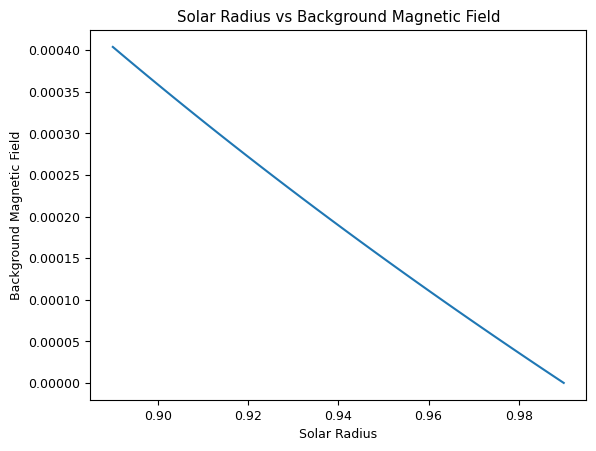

In [ ]:
#Plotting background magnetic field

fig,ax = plt.subplots()

ax.plot(rvec['g'][2][0][0].real, B0['g'][2][0][0].real)
plt.title("Solar Radius vs Background Magnetic Field")
plt.xlabel("Solar Radius")
plt.ylabel("Background Magnetic Field")

Test_MRI_Output


/tmp/ipykernel_2427335/3500378968.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


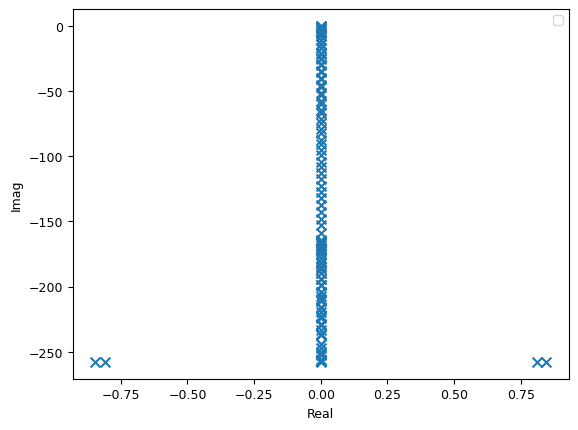

In [ ]:
# Plotting real and imaginary values of the eigenvalues calculated by the EVP solver.

fig,ax=plt.subplots()
print(data_dir)
eig = np.load(data_dir+'/eigenvalues.npy')
ax.scatter(eig.real,eig.imag,marker='x',s=50)

ax.set_xlabel('Real')
ax.set_ylabel('Imag')
ax.legend()

Text(0, 0.5, 'Vorticity')

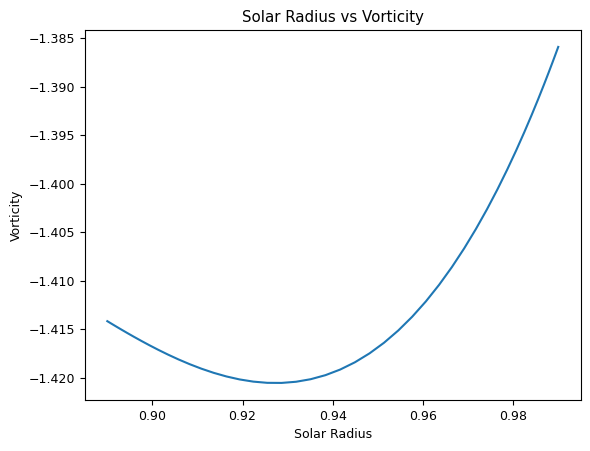

In [ ]:
#plotting vorticity

fig,ax = plt.subplots()

ax.plot(rvec['g'][2][0][0].real, w0['g'][2][0][0].real)
plt.title("Solar Radius vs Vorticity")
plt.xlabel("Solar Radius")
plt.ylabel("Vorticity")

In [ ]:
def compress_axis_average(arr, new_length, axis=0):
    """
    Compress one axis by averaging chunks of an input array into a new length specified by the user
    """
    arr = np.asarray(arr)
    old_length = arr.shape[axis]
    factor = old_length / new_length

    indices = (np.floor(np.arange(old_length) / factor)).astype(int)
    indices = np.clip(indices, 0, new_length - 1)

    if axis == 0:
        result = np.zeros((new_length, arr.shape[1]))
        for i in range(new_length):
            result[i] = arr[indices == i].mean(axis=0)
        return result

    else:
        result = np.zeros((arr.shape[0], new_length))
        for i in range(new_length):
            result[:, i] = arr[:, indices == i].mean(axis=1)
        return result

/tmp/ipykernel_2427335/2190419901.py:71: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.savefig("Testing.png", dpi=600)
/home/lc876/miniconda3/envs/dedalus/lib/python3.13/site-packages/IPython/core/events.py:82: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  func(*args, **kwargs)
/home/lc876/miniconda3/envs/dedalus/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


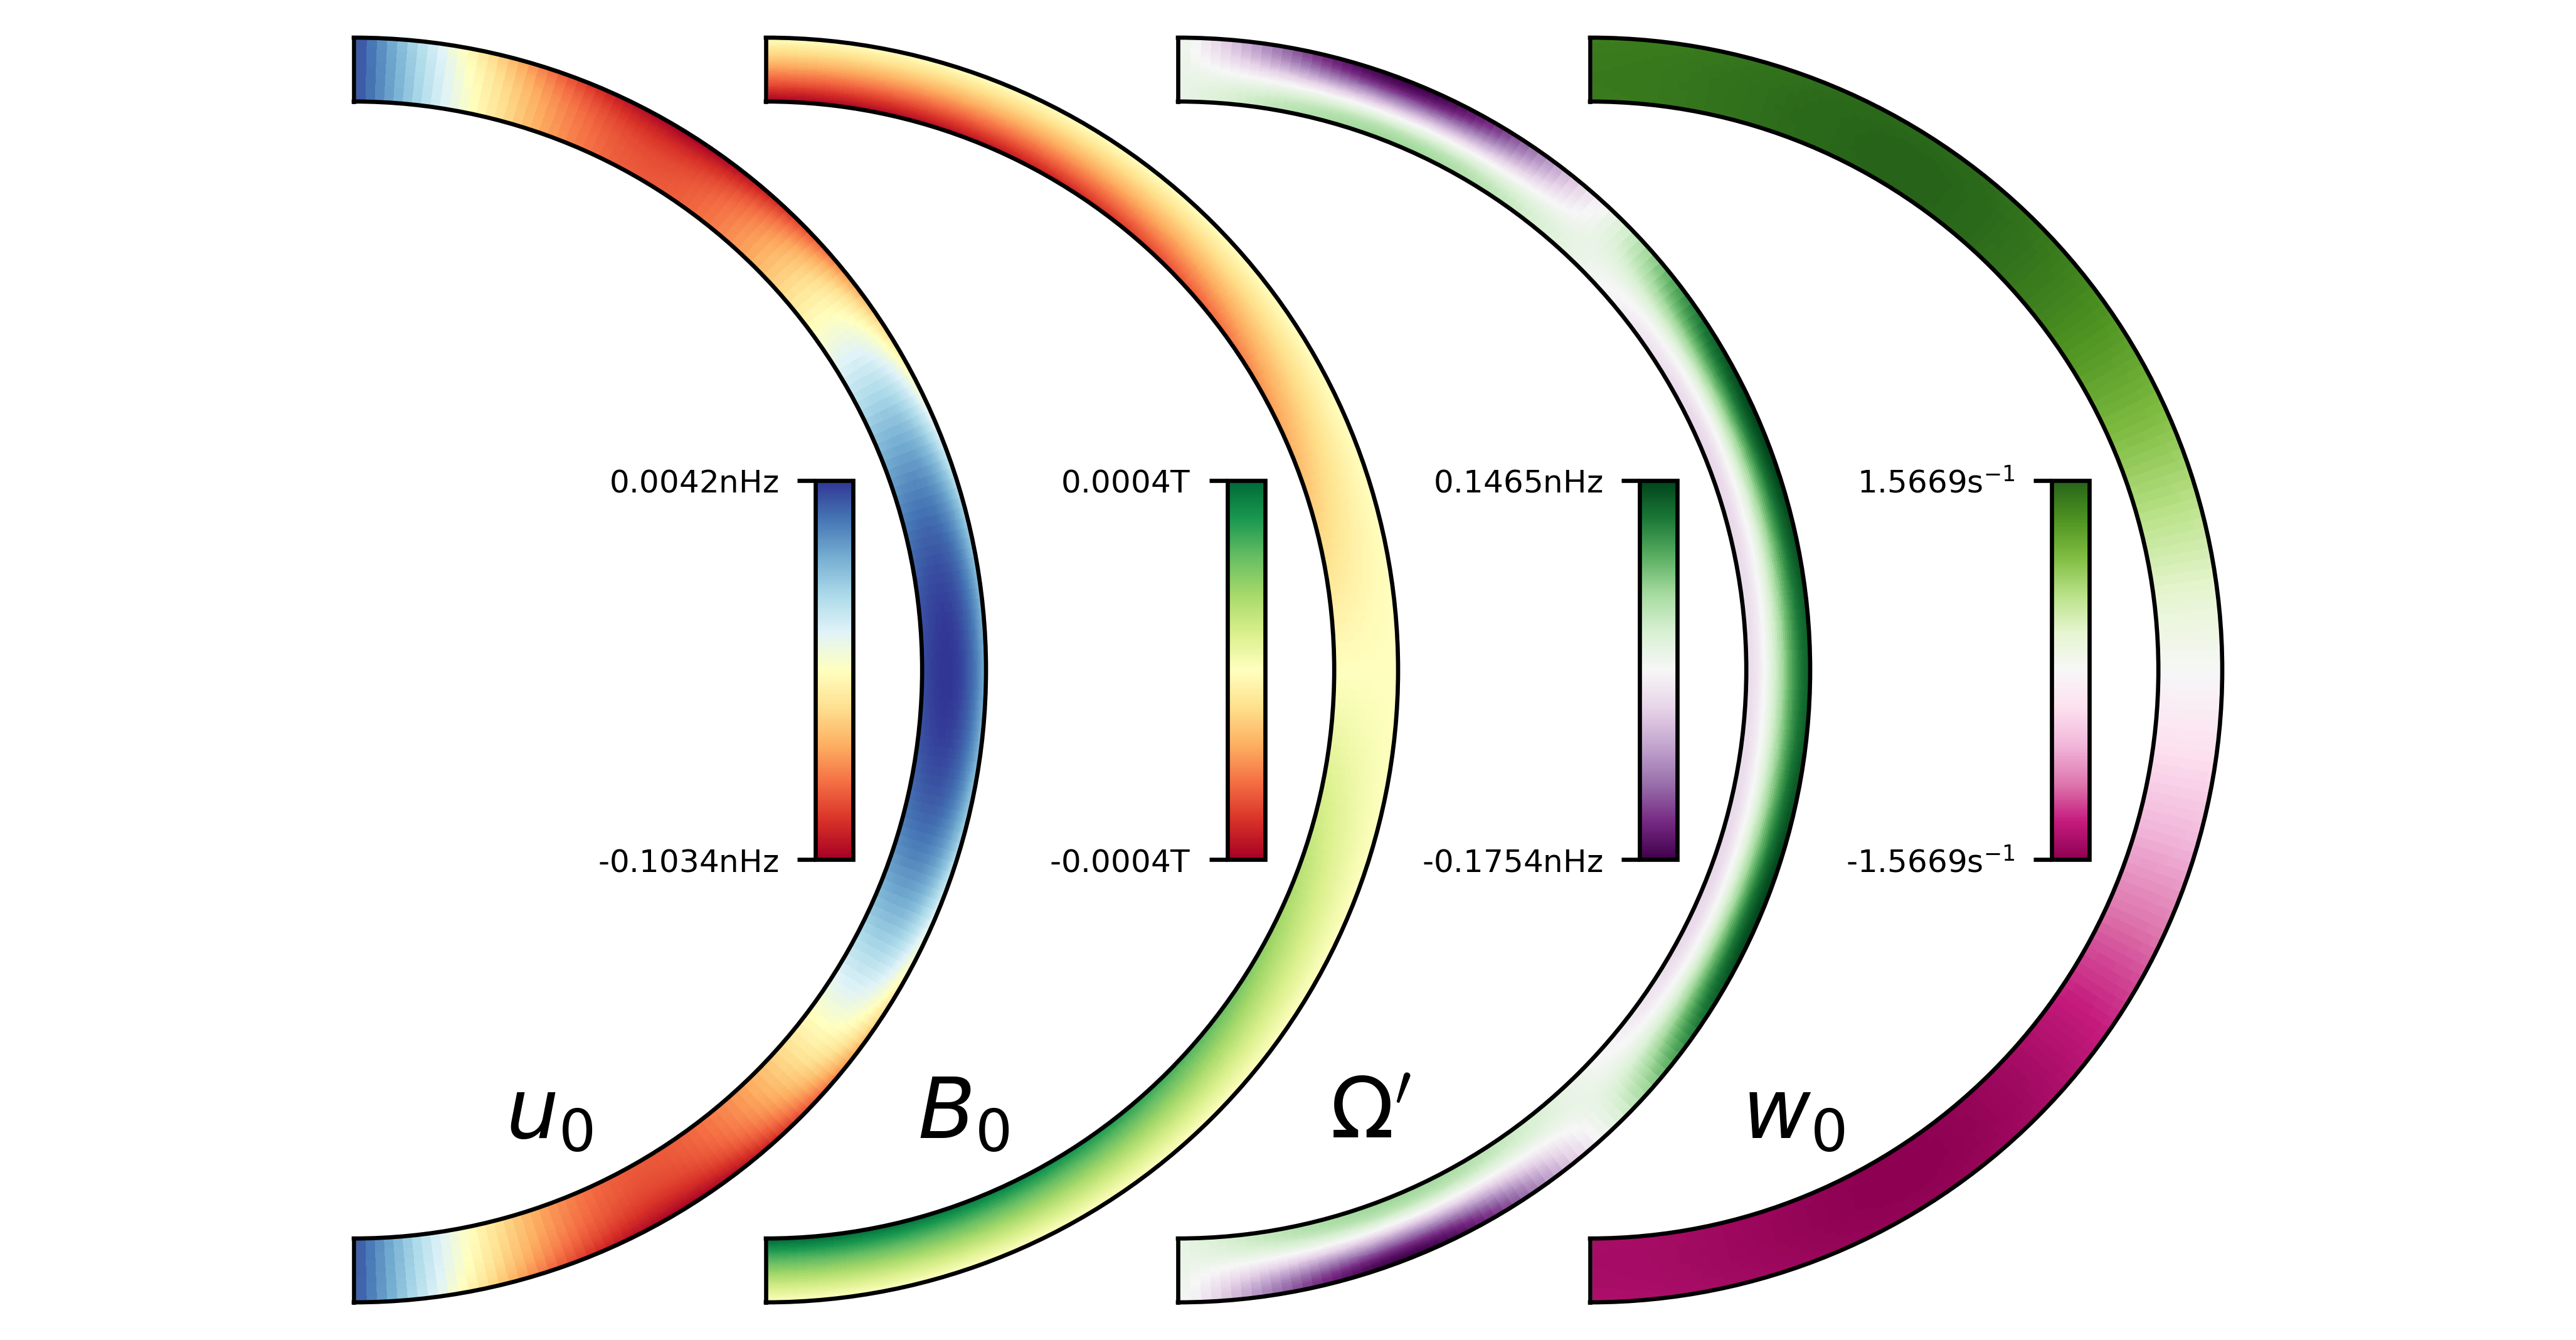

In [ ]:
#Plots the colourmaps of data against the last 10% of the solar radius + latitude spanning from -pi to +pi

labels = [r"$u_{0}$",
            r'$B_{0}$',
            r"$\Omega'$",
            r'$w_{0}$',
            r'$\mathcal{H}$']

unit  = [r'$\mathrm{nHz}$',
            r'$\mathrm{T}$',
            r'$\mathrm{nHz}$',
            r'$\mathrm{s^{-1}}$']

def style(index,value):
        if labels[index] in [r'$\psi$', r'$a_{\phi}$', r'$\mathcal{H}$']:
            return '{:.4f}'.format(value) + unit[index]
        return '{:.4f}'.format(value) + unit[index]

nHz = 2*np.pi * 1e-9
day = 3600 * 24
om0  = 466 * nHz * day
rsun    = 696e8

fig = plt.figure(figsize=[7.3,3.5],constrained_layout=True,dpi=600)
x , y = np.meshgrid(theta[0], rvec['g'][2][0][0].real)
cmaps = ['RdYlBu','RdYlGn','PRGn','PiYG']
datas = [v0['g'][:][0][0].real, B0['g'][2][0][:].real, uu['g'][:][0][0].real, w0['g'][2][0][:].real]


for i in range(len(datas)):
    pos = [ 0.15 * i - 0.265, 0.02, 0.92, 0.96 ]
    pb = fig.add_axes(pos, projection='polar')
    pb.set_xticklabels([])
    pb.set_yticklabels([])
    pb.set_xticks([])
    pb.set_yticks([])

    data = datas[i]
    data2 = np.zeros((288, len(rvec['g'][2][0][0].real)))

    j = 0
    for j in range(288):
        data2[j] = datas[i][j].real  

        


    vmin = min(data2.flatten())
    vmax = max(data2.flatten())
    temp = compress_axis_average(data2, 192)
    meplot = pb.pcolormesh(x, y, temp.T,
                            cmap = cmaps[i], vmin = vmin, vmax =  vmax,
                            rasterized =  False, shading    =  'auto')

    pb.set_theta_direction(-1)
    pb.set_theta_offset(np.pi/2)
    pb.set_thetalim([np.pi,0])
    pb.set_rlim(ri,ro)
    pb.set_rorigin(0)
    pb.set_aspect(1)
    pb.grid(False)

    cbax = inset_axes(pb, width = "3%", height = "30%", loc = 'center',
                          bbox_to_anchor = [0.13, 0, 1, 1], bbox_transform = pb.transAxes)
    mycbar = fig.colorbar(meplot,cax=cbax,orientation='vertical',ticks=[vmin,vmax])
    cbax.yaxis.set_ticks_position('left')
    cbax.set_yticklabels( [style(i, vmin), style(i, vmax)], fontsize = 6 )
    pb.text(0.37, 0.13, labels[i], transform = pb.transAxes,  fontsize = 16 )

fig.savefig("Testing.png", dpi=600)